In [1]:
import numpy as np
import pandas as pd
import os.path
import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize

find the dates of the strongest 30 clustering (14-day window) of Danielle's P99 objects for each huc
- year-day mesh plot <br> 

reference:<br>
https://towardsdatascience.com/5-pandas-group-by-tricks-you-should-know-in-python-f53246c92c94

In [2]:
# explicit function to normalize array
def normalize_2d(matrix):
    norm = np.linalg.norm(matrix)
    matrix = matrix/norm  # normalized matrix
    return matrix

#### read Obj file and group it according to HUC

In [18]:
dir_i = '/glade/campaign/mmm/c3we/COEXIST/ERA5_events/ERA5_events/'
dir_o = '/glade/campaign/mmm/c3we/mingge/COEXIST/PLOT/'

flnm = dir_i + 'ERA5_accumulated_daily_pr_p99_2d_events_1979-2020_US.txt'
print(flnm)

df = pd.read_csv(flnm, sep=" ") 
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

/glade/campaign/mmm/c3we/COEXIST/ERA5_events/ERA5_events/ERA5_accumulated_daily_pr_p99_2d_events_1979-2020_US.txt


In [19]:
# Split Data into 'HUC2' Groups by .groupby() function. 
# This returns a GroupBy object which is a dictionary
# Then use different methods on this object 
huc2_g = df.groupby(['HUC2']) 

In [20]:
# number of unique groups
# the same as df.HUC2.nunique() 
n_huc2 = huc2_g.ngroups 
n_huc2

19

In [21]:
# group size : counts the number of rows in each group
huc2_g.size()

HUC2
Arkansas                1703
CoastalBasinsNP          442
Colorado                3604
Columbia                2947
GreatBasin              2124
GreatLakes              1893
LowerMississippi        1100
LowerMissouri           2198
None                    6787
NorthAtlantic           1251
Ohio                    2162
RedAndOuachita           831
RedRiver                 521
RioGrande               1639
SacramentoAndKlamath     802
Southeast               3052
Texas                   1707
UpperMississippi        1910
UpperMissouri           3316
dtype: int64

#### some info. about the group

In [22]:
huc2_1d = huc2_g.groups.keys() 
huc2_1d

dict_keys(['Arkansas', 'CoastalBasinsNP', 'Colorado', 'Columbia', 'GreatBasin', 'GreatLakes', 'LowerMississippi', 'LowerMissouri', 'None', 'NorthAtlantic', 'Ohio', 'RedAndOuachita', 'RedRiver', 'RioGrande', 'SacramentoAndKlamath', 'Southeast', 'Texas', 'UpperMississippi', 'UpperMissouri'])

In [23]:
# counts only the non-null values from each column
# whereas .size() simply returns the number of rows
# huc2_g.count()

In [24]:
# check the first and last records after data  is split 
# .first() gives first non-null values in each column, whereas .nth(0) returns the first row of the group, no matter what the values are.
# huc2_g.last()

In [25]:
# extracting 4th row in each group
# huc2_g.nth(3)

In [26]:
## extract specific group. get_group is fast
# huc2_g.get_group('Ohio')

In [27]:
# view 'HUC2' Groups
# huc2_g.groups

In [28]:
StartDay = datetime.datetime(1979, 1, 1,  0)
StopDay  = datetime.datetime(2020, 12, 31, 23)

TimeDD = pd.date_range(StartDay, end=StopDay, freq='d')

n_day = len(TimeDD)

n_year = TimeDD.year.max() - TimeDD.year.min() + 1
year_s = TimeDD.year[0]
year_e = TimeDD.year[-1]

# TimeDD

#### find the dates of the strongest 30 clustering (14-day window) of Danielle's P99 objects for each huc

 - 1) Find the date with the highest value, and record it.
 - 2) Set to missing the values at all dates within a period of 14 days after the date
 - 3) Repeat steps 1 and 2 thirty times. 

In [ ]:
# Group By object is a dictionary, iterate through it as with dictionary 
# reference
# https://www.geeksforgeeks.org/how-to-calculate-moving-averages-in-python/
# 14-day running sum
window_size = 14
 
n_ActDD = n_day - window_size + 1

n_cluster = 30
#n_cluster = 2 #for testing

for name_of_group, contents_of_group in huc2_g: 
    event_date = contents_of_group[['event_id', 'date']]
     
    #print(event_date.head())
    flnm_o = dir_o + 'p99_cluster_' + name_of_group + '.csv'
    
    if os.path.exists(flnm_o):
        print(flnm_o, 'exist')
        continue
     
    nc = 0
    arr30_1d = []
    TimeDD30_1d = []
    
    # find TOP n_cluster
    while nc < n_cluster:
        arr_1d  = np.zeros((n_ActDD), dtype=int)
        # Loop through the TimeDD array to consider
        # every window of size 14
        i = 0
        while i < n_ActDD:
            window = TimeDD[i : i + window_size]
            
            # select rows between two values
            event_select = event_date[event_date['date'].between(window[0], window[-1])]
         
            if not event_select.empty:
                arr_1d[i] = event_select['event_id'].nunique()
                #print('event_select:',event_select)
            i += 1
     
        # get the first index of maximum
        indices = np.argmax(arr_1d, axis=0) 
        
        arr30_1d.append(arr_1d[indices])
        TimeDD30_1d.append(str(TimeDD[indices].date()))
        #print(TimeDD30_1d,  arr30_1d, nc) 
        print(nc,TimeDD[indices], arr_1d[indices])
        window_max = TimeDD[indices : indices + window_size]
        
        # exclude dates for the next biggest cluster
        event_date = event_date.loc[(event_date['date'] < window_max[0]) 
                                | (event_date['date'] > window_max[-1])]
        
        nc += 1 
    print('nc=', nc) 
    # create a dataframe use date as index, huc2_g.groups.keys() as columns
    # and drop 'None':axis{0 or ‘index’, 1 or ‘columns’}, default 0
    df = pd.DataFrame(arr30_1d, columns = ['# of objs'],
                index = TimeDD30_1d)#, dtype = int).drop(['None'], axis=1) 
    df.to_csv(flnm_o)  
    print('output file:', flnm_o)
    

0 1997-08-05 00:00:00 14
1 1989-05-31 00:00:00 13
2 2017-07-30 00:00:00 13
3 1992-06-15 00:00:00 11
4 2000-06-11 00:00:00 11
5 2004-06-18 00:00:00 11
6 2005-08-10 00:00:00 10
7 2006-08-14 00:00:00 10
8 2018-08-09 00:00:00 10
9 1983-05-28 00:00:00 9
10 1995-05-22 00:00:00 9
11 1995-07-11 00:00:00 9
12 2009-04-27 00:00:00 9
13 2015-07-29 00:00:00 9
14 2017-03-22 00:00:00 9
15 1985-09-16 00:00:00 8
16 1987-06-29 00:00:00 8
17 1992-05-26 00:00:00 8
18 1993-04-26 00:00:00 8
19 1999-06-28 00:00:00 8
20 2002-05-23 00:00:00 8
21 2009-08-07 00:00:00 8
22 1979-05-27 00:00:00 7
23 1980-06-07 00:00:00 7
24 1981-05-21 00:00:00 7
25 1982-05-11 00:00:00 7
26 1986-05-27 00:00:00 7
27 1987-08-14 00:00:00 7
28 1989-08-01 00:00:00 7
29 1993-07-24 00:00:00 7
nc= 30
output file: /glade/campaign/mmm/c3we/mingge/COEXIST/PLOT/p99_cluster_Arkansas.csv
0 1982-03-31 00:00:00 5
1 1983-07-12 00:00:00 4
2 1985-10-14 00:00:00 4
3 1986-09-12 00:00:00 4
4 1988-05-20 00:00:00 4
5 1990-05-28 00:00:00 4
6 1992-06-22 00:0

In [31]:
n_366 = 366
arr_2d = np.empty((n_year, n_366,))
arr_2d[:] = np.nan
arr_2d[:] = 0

# the outputs of meshgrid are of shape (N, M) for ‘xy’ indexing and (M, N) for ‘ij’ indexing.
# default 'xy' indexing
day_2d, year_2d = np.meshgrid(range(1, n_366+1), range(year_s, year_e+1))

p99_cluster_Arkansas.csv
p99_cluster_CoastalBasinsNP.csv
p99_cluster_Colorado.csv
p99_cluster_Columbia.csv
p99_cluster_GreatBasin.csv
p99_cluster_GreatLakes.csv
p99_cluster_LowerMississippi.csv
p99_cluster_LowerMissouri.csv
p99_cluster_NorthAtlantic.csv
p99_cluster_Ohio.csv
p99_cluster_RedAndOuachita.csv
p99_cluster_RedRiver.csv
p99_cluster_RioGrande.csv
p99_cluster_SacramentoAndKlamath.csv
p99_cluster_Southeast.csv
p99_cluster_Texas.csv
p99_cluster_UpperMississippi.csv
p99_cluster_UpperMissouri.csv


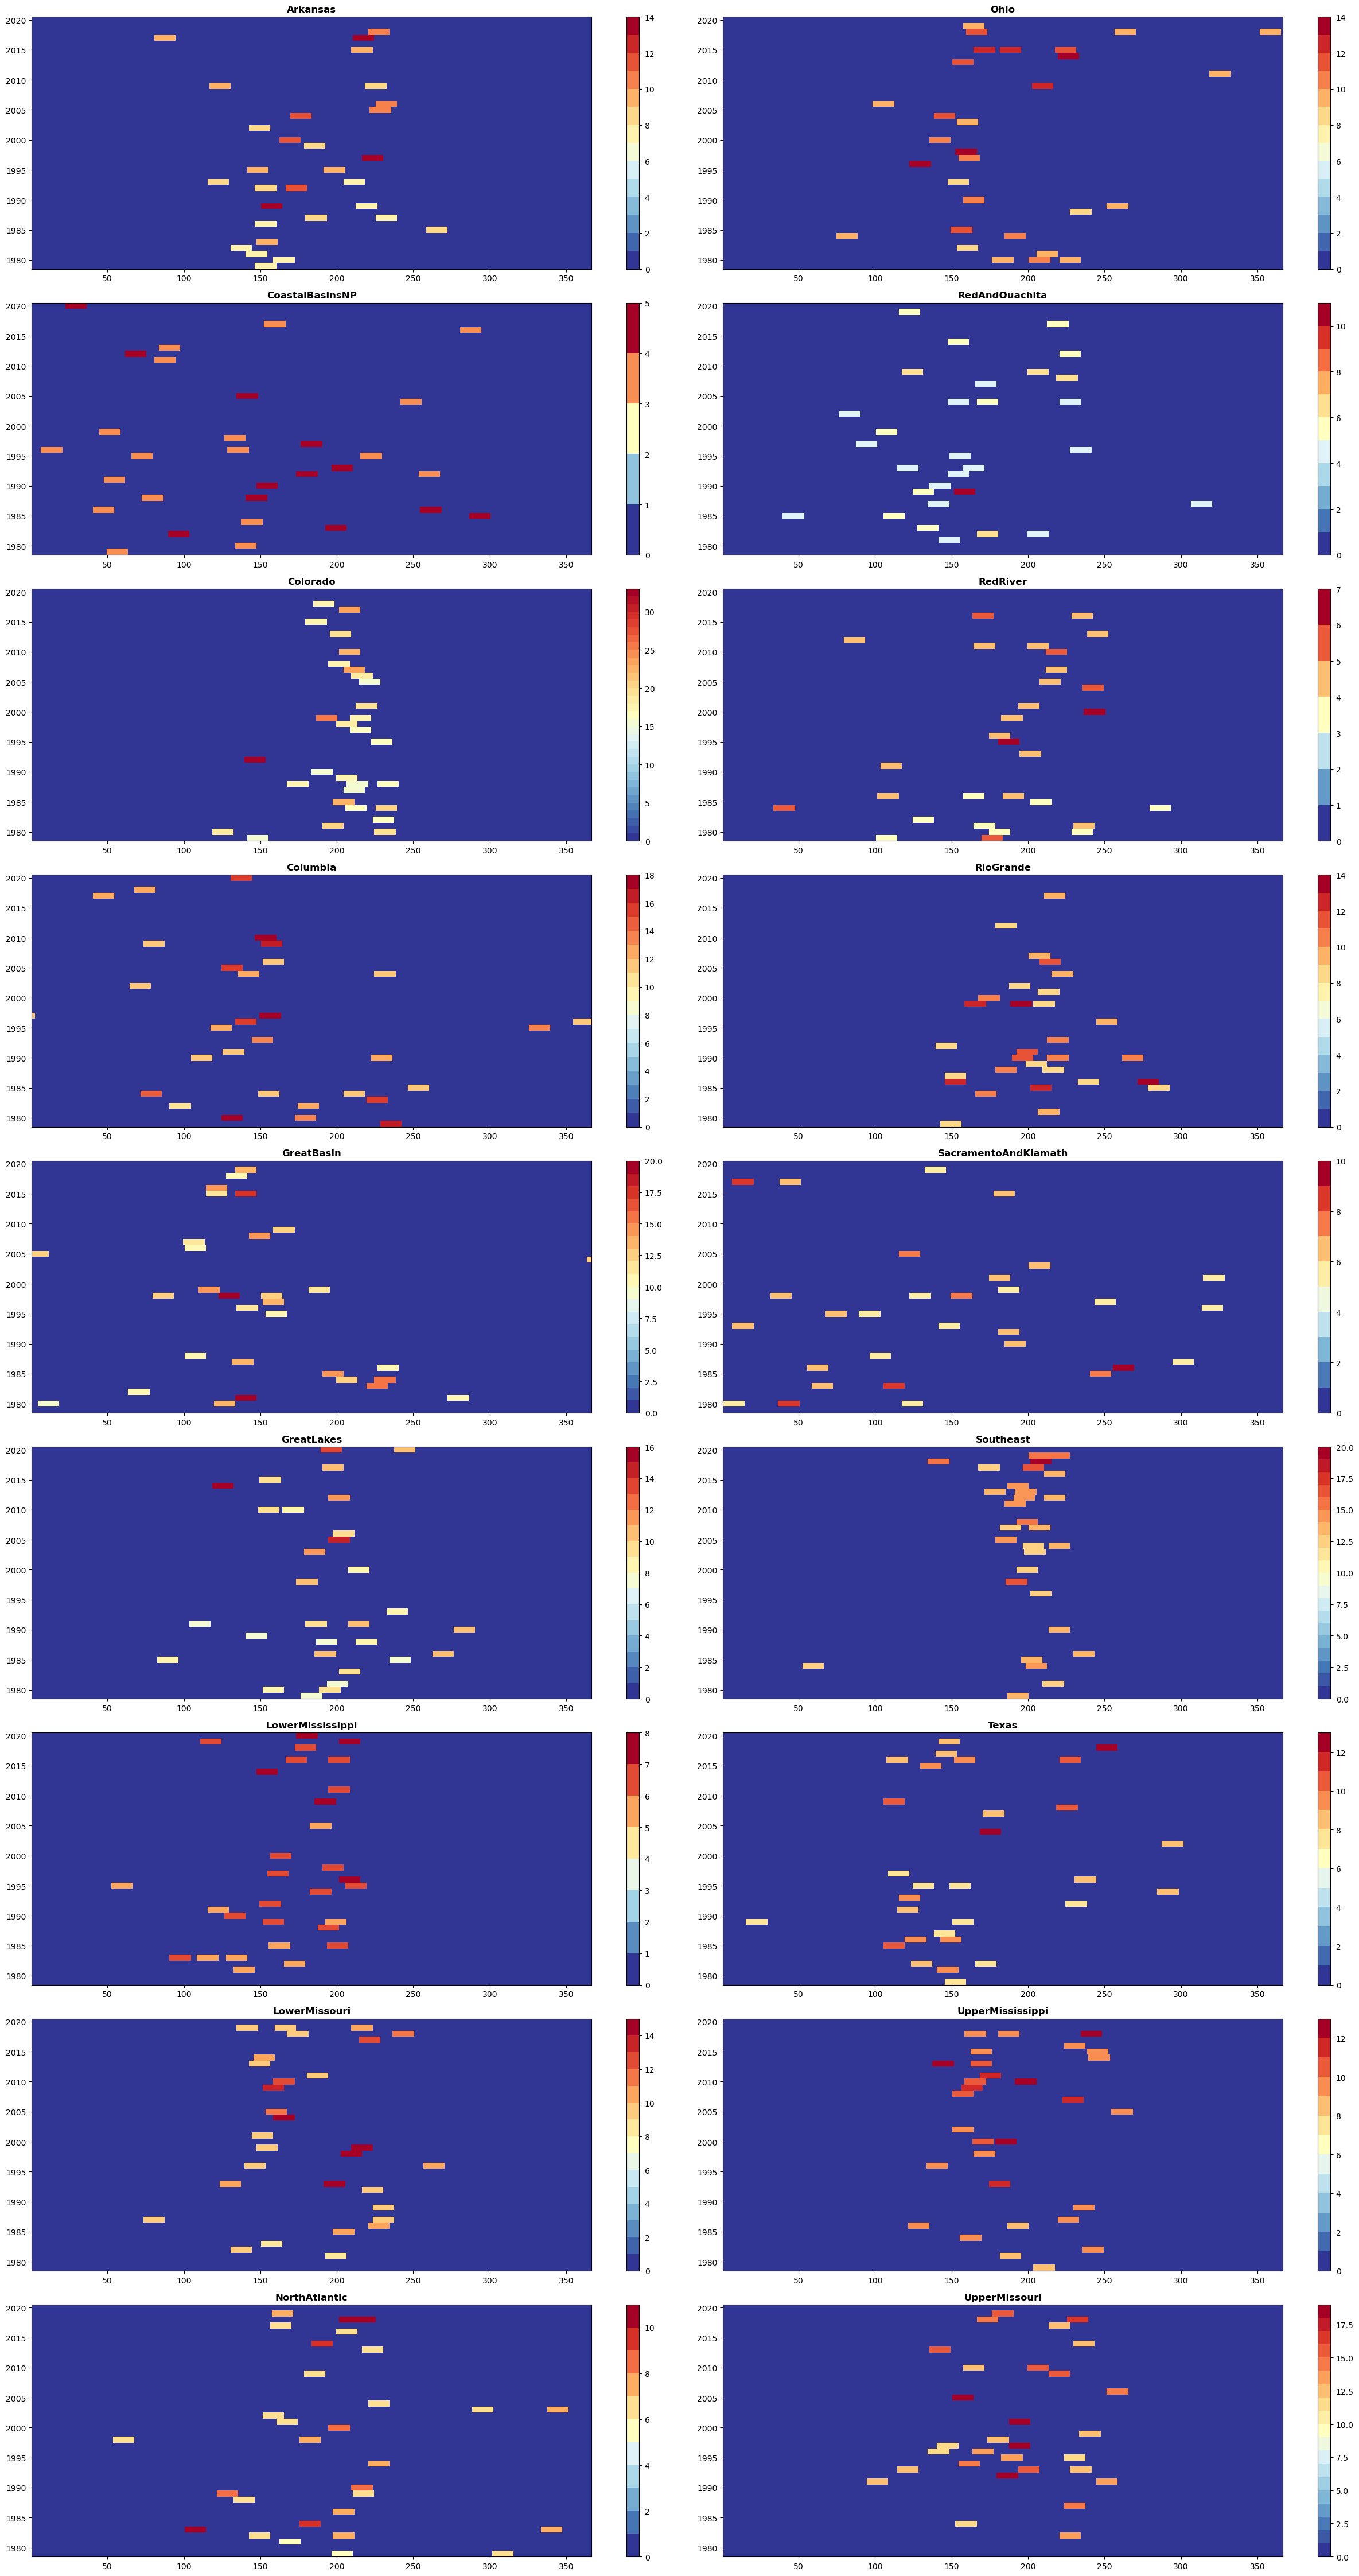

In [33]:
fig, ax = plt.subplots(9,2,figsize=(25, 45))

ct = 0
for hucs in huc2_1d:
  if hucs != 'None':
    jj = int(ct/9)
    ii = ct - jj*9
    flnm = 'p99_cluster_' + hucs + '.csv'
     
    print(flnm)
    df0 = pd.read_csv(flnm, index_col= 0)
    
    # use reindex to add missing dates to pandas dataframe
    ## note: use  pandas.DatetimeIndex
    df0.index = pd.DatetimeIndex(df0.index)
    date_1d = df0.index
    
    df0 = df0.reindex(TimeDD, fill_value=0 )
   
    df = df0.copy()
 
    for date_0 in date_1d:
         df.loc[pd.date_range(date_0,periods=14, freq='d')] = df.loc[date_0].values

    data = {'year':pd.DatetimeIndex(df.index).year,
            hucs: df['# of objs']}
    df_new = pd.DataFrame(data)
         
    
    for year in range(year_s, year_e+1):
        iTT = np.isin(df_new.year, year)
        id_iTT = np.where(iTT == True)[0]
        arr_2d[year-year_s, :len(id_iTT)] = df_new[hucs][id_iTT]
     
    # the pcolormesh() method to create a pseudocolor plot with a non-regular rectangular grid.
    im = ax[ii,jj].pcolormesh(day_2d, year_2d, arr_2d, cmap= plt.cm.get_cmap('RdYlBu_r', np.amax(arr_2d)))
    fig.colorbar(im, ax=ax[ii,jj])
    ax[ii,jj].set_title(hucs, fontweight ="bold")
    ct +=1 
    
plt.tight_layout()
plt.savefig(dir_o + 'n_p99_year_day.pdf', format='pdf', dpi=300);

In [17]:
StartDay = datetime.datetime(1979, 1, 1,  0)
pd.date_range(StartDay,periods=14, freq='d')

DatetimeIndex(['1979-01-01', '1979-01-02', '1979-01-03', '1979-01-04',
               '1979-01-05', '1979-01-06', '1979-01-07', '1979-01-08',
               '1979-01-09', '1979-01-10', '1979-01-11', '1979-01-12',
               '1979-01-13', '1979-01-14'],
              dtype='datetime64[ns]', freq='D')

p99_cluster_Arkansas.csv
p99_cluster_CoastalBasinsNP.csv
p99_cluster_Colorado.csv
p99_cluster_Columbia.csv
p99_cluster_GreatBasin.csv
p99_cluster_GreatLakes.csv
p99_cluster_LowerMississippi.csv
p99_cluster_LowerMissouri.csv
p99_cluster_NorthAtlantic.csv
p99_cluster_Ohio.csv
p99_cluster_RedAndOuachita.csv
p99_cluster_RedRiver.csv
p99_cluster_RioGrande.csv
p99_cluster_SacramentoAndKlamath.csv
p99_cluster_Southeast.csv
p99_cluster_Texas.csv
p99_cluster_UpperMississippi.csv
p99_cluster_UpperMissouri.csv


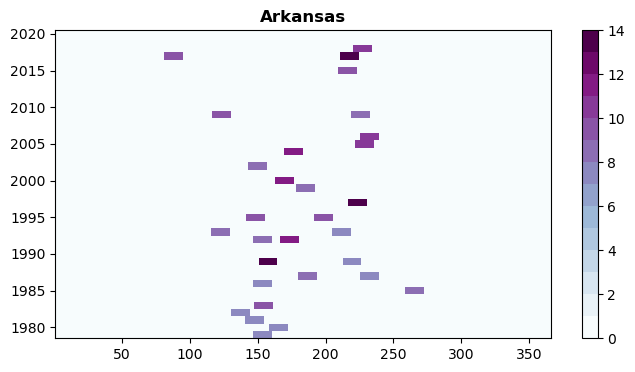

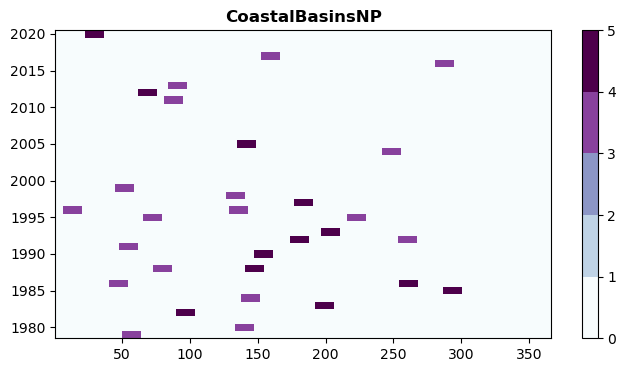

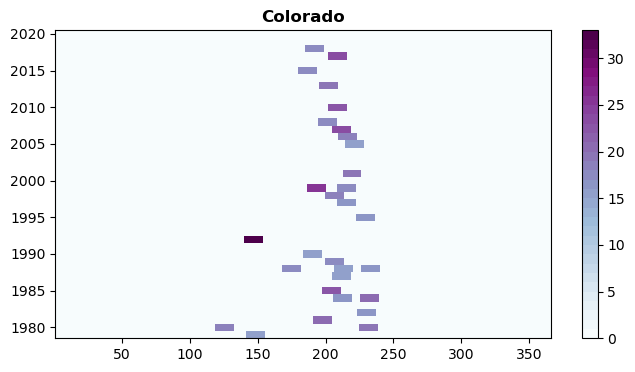

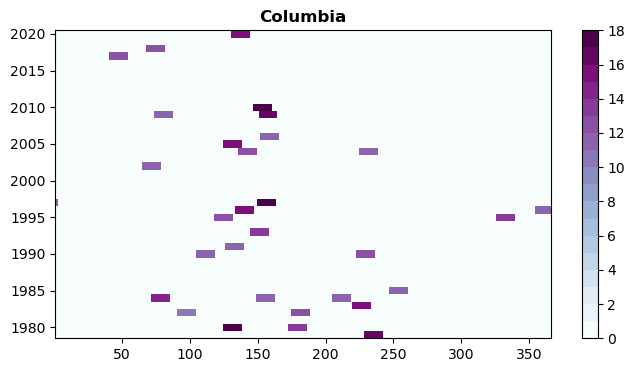

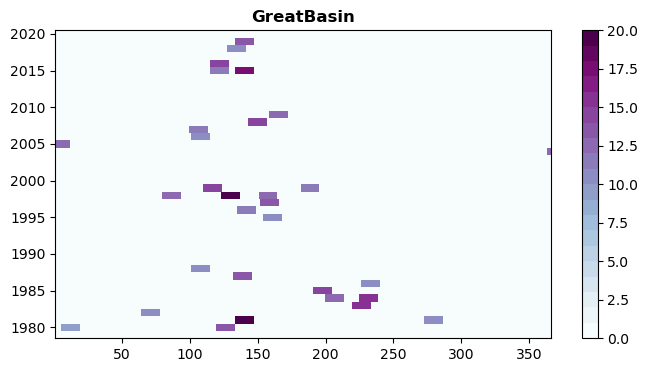

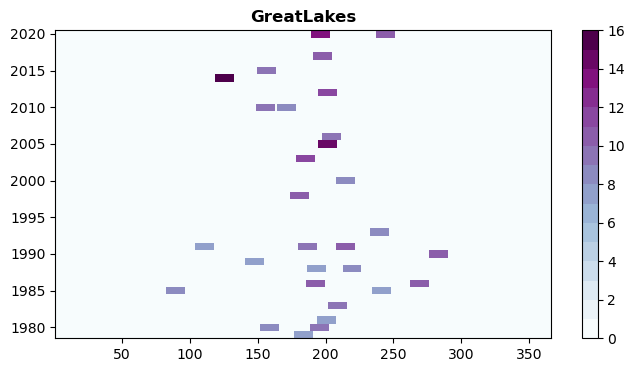

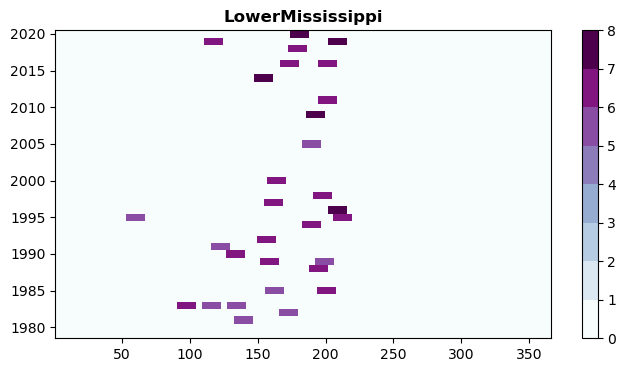

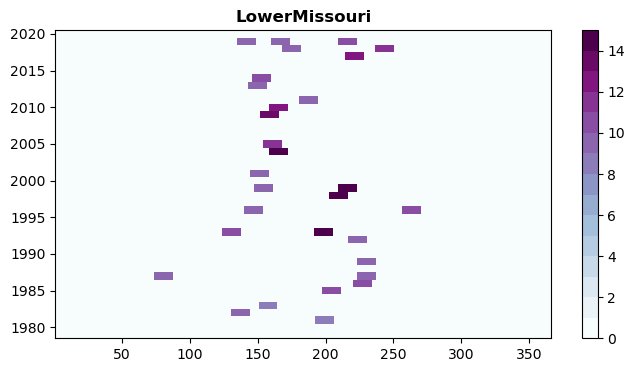

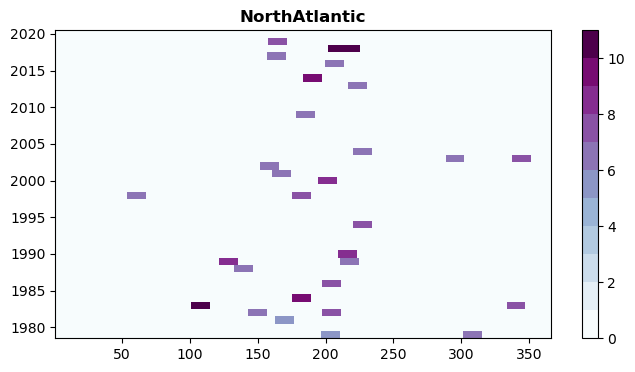

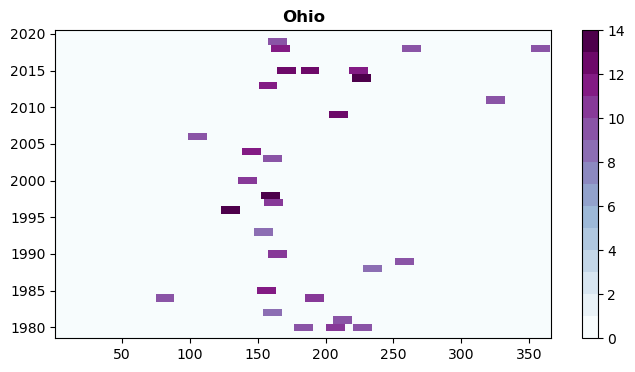

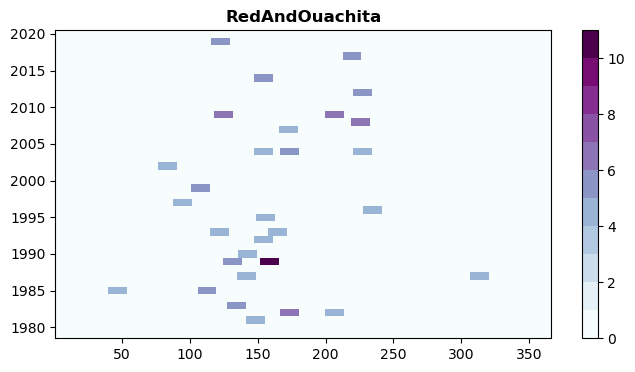

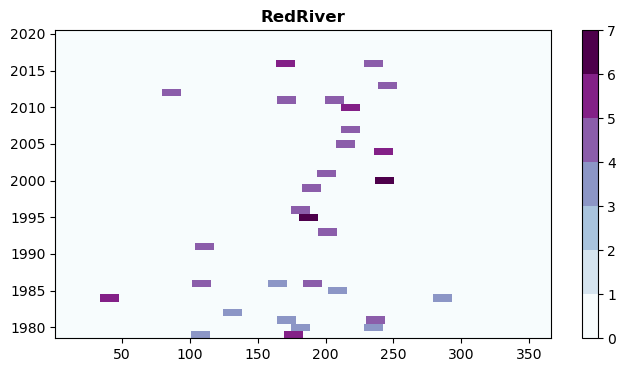

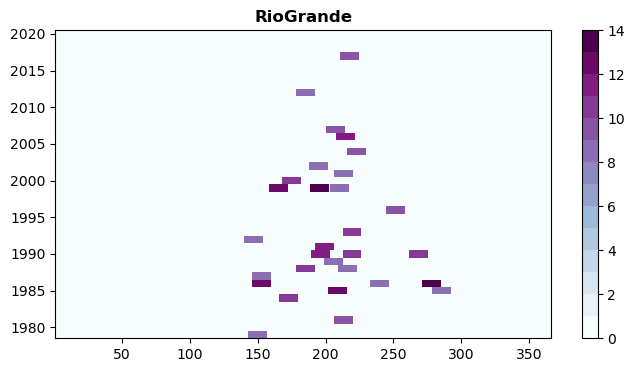

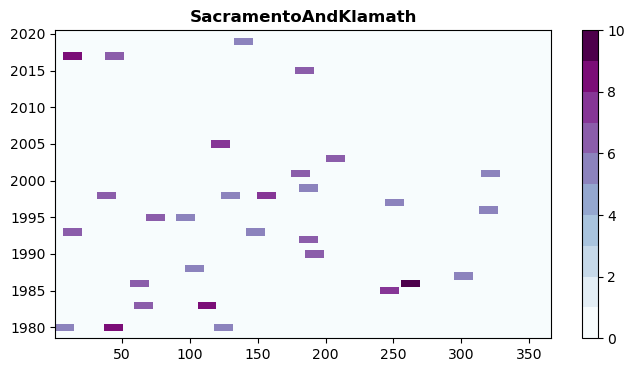

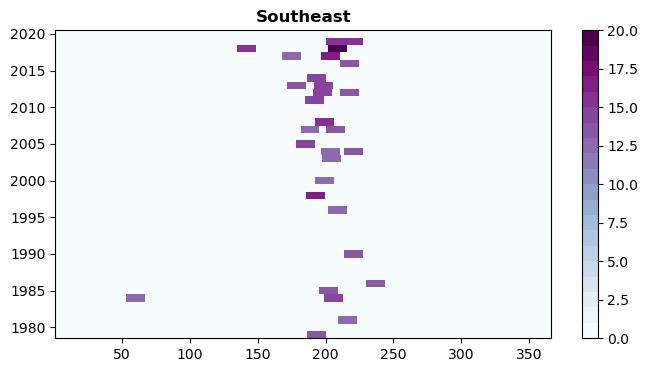

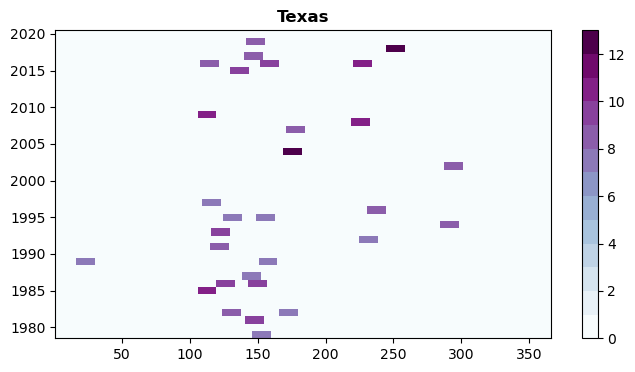

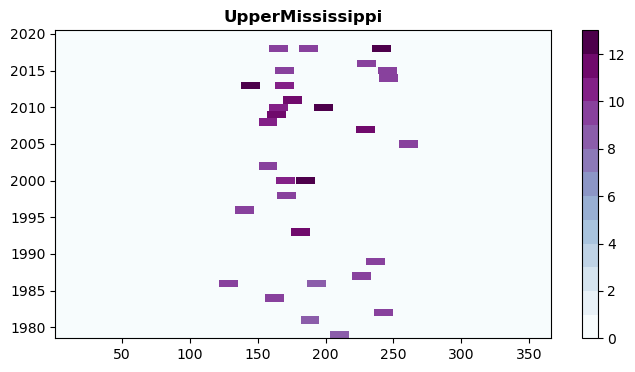

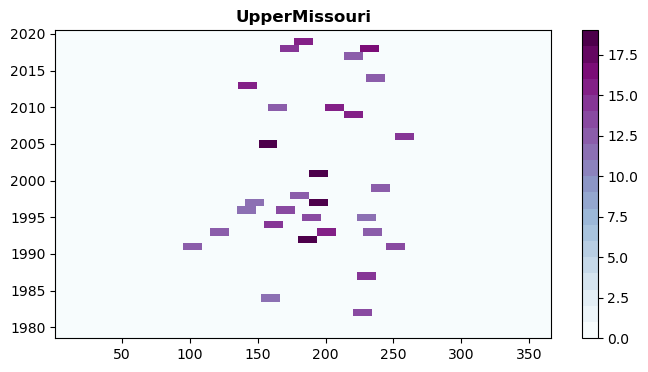

In [34]:
for hucs in huc2_1d:
  if hucs != 'None':
    flnm = 'p99_cluster_' + hucs + '.csv'     
    print(flnm)
    
    df0 = pd.read_csv(flnm, index_col= 0)
    df0 = df0.sort_index()
    # use reindex to add missing dates to pandas dataframe
    ## note: use  pandas.DatetimeIndex
    df0.index = pd.DatetimeIndex(df0.index)
    
    date_1d = df0.index
     
    df0 = df0.reindex(TimeDD, fill_value=0 )
    
    df = df0.copy()
 
    for date_0 in date_1d:
         df.loc[pd.date_range(date_0,periods=14, freq='d')] = df.loc[date_0].values

    data = {'year':pd.DatetimeIndex(df.index).year,
            hucs: df['# of objs']}
    df_new = pd.DataFrame(data)
     
    for year in range(year_s, year_e+1):
        iTT = np.isin(df_new.year, year)
        id_iTT = np.where(iTT == True)[0]
         
        arr_2d[year-year_s, :len(id_iTT)] = df_new[hucs][id_iTT]
     
    fig, ax = plt.subplots(figsize=(8, 4)) 
    
    
    # the pcolormesh() method to create a pseudocolor plot with a non-regular rectangular grid.
    im=ax.pcolormesh(day_2d, year_2d, arr_2d, cmap= plt.cm.get_cmap('BuPu', np.amax(arr_2d)))
    fig.colorbar(im, ax=ax)
    ax.set_title(hucs, fontweight ="bold")
    
    plt.savefig(dir_o + 'n_p99_year_day_'+hucs+'.pdf', format='pdf', dpi=300);     
    